Ejercicio 1. Leer el artículo *Computational geometry in practice* de A.R. Forest y dar un resumen de los problemas que se encontrarían en la
implementación del parity algorithm.

En la sección 3 se mencionan dos casos especiales que generan dificultades geometricas:

1. El rayo pasa por un vertice del poligono (ver Figura 2). Sea B este vertice y denotemos por A y C a los vertices adyacentes a B. La solución propuesta es la siguiente: (i) Si A y C estan del mismo lado del semiplano definido por el rayo, no contamos esta intersección. (ii) Si A y C estan en lados opuestos del semiplano definido por el rayo, contamos esta intersección. Cabe recalcar que en este caso estamos suponiendo que los segmentos AB y BC no estan contenidos en el rayo.
2. El rayo coincide con uno de los lados del poligono (ver Figura 3). Sea BC este lado y denotemos por A y D a los otros vertices adyacentes a B y C respectivamente. La solución propuesta es la siguiente: (i) Si A y D estan del mismo lado del semiplano definido por el rayo, no contamos esta intersección. (ii) Si A y D estan en lados opuestos del semiplano definido por el rayo, contamos esta intersección.

El artículo también menciona la necesidad de definir si consideramos a la frontera como adentro o afuera del poligono. En el primer caso, la intersección del semi rayo con el poligono en el vértice debe contar y en el segundo no. En la sección 4 también se mencionan dificultades numericas que se encuentran al intentar calcular explicitamente el punto de intersección. En la implementación del parity algorithm que presentaremos, nunca calculamos explicitamente un punto de intersección; sin embargo, los problemas numericos causados por redondeo y truncación (floating point arithmetic) si son relevantes. Por ejemplo, cuando las lineas son casi paralelas. Transformar las lineas para obtener lineas 'mas perpendiculares' no necesariamente resuelve el problema pues la misma transformación puede ser causa de errores. La única solución mencionada es: normalizar los coeficientes de las ecuaciones y poner atención al orden en el que hacemos operaciones aritmeticas. En la implementación del parity algorithm que presentaremos, esta dificultad se manifiesta al determinar si un punto esta en la frontera del poligono. Cuando sea adecuado, mencionaremos la solución presentada.

Ejercicio 2. Encuentre una manera de producir de manera aleatoria curvas cerradas simples en el plano.

La idea basica del metodo que usaremos es la siguiente:
1. Generar puntos aleatorios en el cuadrado unitario.
2. Constuir la frontera de la $\alpha$-forma asociada a estos puntos (con $\alpha \geq 0$).

En lo que sigue, precisamos esto pero antes presentamos la teoria necesaria:

Sean $x_1, \dots, x_n \in \mathbb{R}^2$. Una *triangulación de Delaunay* asociada a $x_1, \dots, x_n$ es una triangulación de $x_1, \dots, x_n$ que subdivide la envolvente convexa de $x_1, \dots, x_n$ en triangulos cuyos circuncirculos no contienen ningun $x_k$ en su interior.

https://en.wikipedia.org/wiki/Delaunay_triangulation#/media/File:Delaunay_circumcircles_vectorial.svg

Se puede demostrar que esta triangulación siempre existe pero no necesariamente es única.

Para cada $\alpha \geq 0$, la $\alpha$-forma asociada a $x_1, \dots, x_n$ es el subcomplejo de la triangulación de Delauney formado por los triangulos con circunradio menor o igual a $\alpha$. Como no estamos interesados en los triangulos interiores, en lo que sigue, cuando hablamos de una $\alpha$-forma, nos referimos simplemente a su frontera. Algunas observaciones:

* Si $\alpha$ es mayor a todos los circunradios, la $\alpha$-forma coincide con la envolvente convexa.
* Si $\alpha$ es menor a todos los circunradios, la $\alpha$-forma es vacía.
* Una $\alpha$-forma puede puede ser un conjunto de poligonos disjuntos. Este caso no presenta dificultades para la implementación del parity algorithm y por lo tanto, lo permitimos.
* Una $\alpha$-forma puede tener poligonos pegados por un vertice. Este caso sí presenta dificultades para la implementación y por lo tanto, tomaremos medidas para nunca considerar $\alpha$-formas de esta forma.

El siguiente resultado sera útil. Sea $T$ un triangulo con lados $a,b,c$. Entonces el area $A_T$ de $T$ esta dada por

$$
A_T = \sqrt{s(s-a)(s-b)(s-c)} \qquad \text{ donde } \qquad s = \frac{a+b+c}{2}.
$$

Más aun, el circunradio $r_T$ de $T$ esta dado por

$$
r_T = \frac{abc}{4A_T}.
$$

Con esto en mente, podemos explicar el siguiente codigo. En este se define una función que tiene dos inputs: (i) un numpy array de forma (N,2) y (ii) un $\alpha \in \mathbb{R}$. Su output es una lista de los ejes que conforman la $\alpha$-forma. La idea es la siguiente:

1. Definimos una lista vacia edges = [ ]
2. Definimos una función add_boundary_edge(edges, p, q) para agregar solo los ejes que son de la frontera. Para decidir esto, observamos que un eje no es de la frontera si y solo si pertenece a dos triangulos diferentes.
3. Creamos la triangulación de Delaunay de los puntos (usando la función Delaunay() de scipy.spatial).
4. Hacemos un for loop sobre los triangulos en la triangulación de Delaunay que calcula el circunradio del triangulo usando las formulas mencionadas anteriormente. Si el circunradio es menor o igual a $\alpha$, aplicamos la funcion add_boundary_edge a cada uno de los lados del triangulo.

In [1]:
from scipy.spatial import Delaunay
import numpy as np

def alpha_shape(points, alpha):

  edges = []

  def add_boundary_edge(edges, p, q):
    if (q,p) in edges:
      edges.remove((q,p))
    else:
      edges.append((p,q))

  tri = Delaunay(points)

  for ia, ib, ic in tri.simplices:
    pa = points[ia]
    pb = points[ib]
    pc = points[ic]
    a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
    b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
    c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
    s = (a + b + c) / 2.0
    area = np.sqrt(s * (s - a) * (s - b) * (s - c))
    circum_r = a * b * c / (4.0 * area)
    if circum_r <= alpha:
      add_boundary_edge(edges, (pa[0],pa[1]), (pb[0],pb[1]))
      add_boundary_edge(edges, (pb[0],pb[1]), (pc[0],pc[1]))
      add_boundary_edge(edges, (pc[0],pc[1]), (pa[0],pa[1]))

  return edges

Definimos una función para graficar los polinomios.

In [2]:
import matplotlib.pyplot as plt

def plot_points_edges(points, edges):
    fig, ax = plt.subplots()
    plt.plot(points[:, 0], points[:, 1], 'bo')
    for (x1, y1), (x2, y2) in edges:
        ax.plot([x1, x2], [y1, y2], 'bo-')
    plt.show()

Generamos una $\alpha$-forma aleatoria. Especificamente,

1. Generamos un entero aleatorio $N$ entre el 4 y el 20.
2. Generamos $N$ puntos aleatorios en el cuadrado unitario.
3. Generamos una $\alpha$ aleatoria.
4. Usamos la funcion alpha_shape para estos puntos y esta alpha.
5. La graficamos.

Cada que corremos esta celda, se genera una nueva $\alpha$-forma aleatoria.

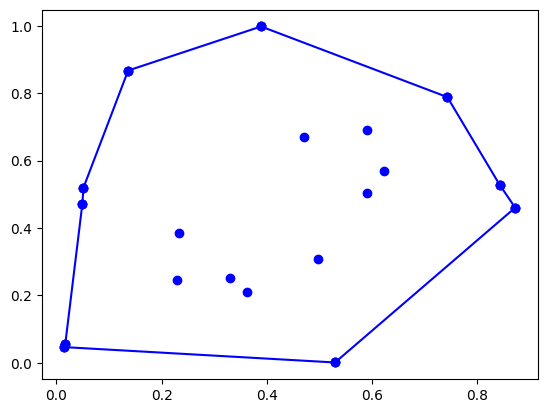

In [3]:
points = np.random.rand(np.random.randint(3,20), 2)
edges = alpha_shape(points, alpha=np.random.rand())
plot_points_edges(points, edges)

Ejercicio 3. Implemente el parity algorithm.

La idea es: primero identificamos si el punto pertenece a la frontera, y en caso de que no, calculamos el numero de intersecciones usando las ideas presentadas en el libro de Edelsbrunner. Especificamente,

1. Checamos si $(x_1,x_2)$ es un vertice.
2. Checamos si $(x_1,x_2)$ esta en uno de los lados $\overline{(a_1,a_2)(b_1,b_2)}$. Para esto, hacemos un for loop sobre todos los lados, considerando los siguientes dos casos: Caso 1. $a_1 \not = b_1$ y $a_2 \not = b_2$. En este caso, $(x_1,x_2) \in \overline{(a_1,a_2)(b_1,b_2)}$ si y solo si
$$
\exists t \in (0,1) \text{ tal que } (x_1,x_2) = t(a_1,a_2) + (1-t)(b_1,b_2)
$$
y esto es si y solo si
$$
0 < \frac{x_1-b_1}{a_1-b_1} = \frac{x_2-b_2}{a_2-b_2} < 1.
$$
En la implementación, verificar la igualdad de estos cocientes presenta dificultades numericas. Por eso, en vez de pedir igualdad, pedimos que su diferencia sea muy chica.
Caso 2. $a_1 = b_1$ o $a_2 = b_2$. Si $a_1 = b_1$, entonces $(x_1,x_2) \in \overline{(a_1,a_2)(b_1,b_2)}$ si y solo si
$$
x_1 = a_1 \qquad \text{ y } \qquad \min(a_2,b_2) < x_2 < \max(a_2,b_2).
$$
El caso $a_2 = b_2$ se trata de manera analoga.
3. Usamos las ideas en el libro de Edelsbrunner. Especificamente, hacemos un for loop sobre todos los lados donde lo primero que hacemos es determinar si los tres puntos estan en posicion generica. Recordemos que esto sucede si y solo si (i) $a_2 < b_2$, (ii) los puntos no son colineales, equivalentemente $\det \Delta(x,a,b) \not = 0$ y (iii) sucede que
$$
a_1 \not = x_1 \not = b_1 \qquad \text{ y } \qquad a_2 \not = x_2 \not = b_2.
$$
Habiendo verificado que estan en posición generica, verificamos la siguiente condición:
$$
a_2 < x_2 < b_2 \qquad \text{ y } \qquad \det \Delta(x,a,b) > 0.
$$
En caso de que se satisfaga, contamos la intersección. Ahora bien, si los puntos no estan en posición generica, consideramos $(x_1 + \epsilon_1, x_2 + \epsilon_2)$ con $0 < \epsilon_1 << \epsilon_2$, en vez de $(x_1,x_2)$ y procedemos como en el caso generico.

In [4]:
def parity_algorithm(x1, x2, edges):

  vertices = []

  for i in range(len(edges)):
    vertices.append(edges[i][0])
    vertices.append(edges[i][1])

  if (x1, x2) in vertices:
    return print(f'({x1}, {x2}) is a vertex.')

  for (a1, a2), (b1, b2) in edges:
    if a1 != b1 and a2 != b2:
      if abs((x1-b1)/(a1-b1) - (x2-b2)/(a2-b2)) < 0.000001 and 0 < (x2-b2)/(a2-b2) and (x2-b2)/(a2-b2) < 1:
        return print(f'({x1}, {x2}) is a boundary point of the edge [({a1}, {a2}), ({b1}, {b2})].')
    else:
      if (a1 == b1 and x1 == a1 and min(a2,b2) < x2 and x2 < max(a2,b2)) or (a2 == b2 and x2 == a2 and min(a1,b1) < x1 and x1 < max(a1,b1)):
        return print(f'({x1}, {x2}) is a boundary point of the edge [({a1}, {a2}), ({b1}, {b2})].')

  count = 0

  for (a1, a2), (b1, b2) in edges:

    if b2 < a2:
        a1, a2, b1, b2 = b1, b2, a1, a2

    det = (a1*b2 - b1*a2) - (x1*b2 - b1*x2) + (x1*a2 - a1*x2)

    if det != 0 and x1 != a1 and x1 != b1 and x2 != a2 and x2 != b2:
      if a2 < x2 and x2 < b2 and det > 0:
        count += 1

    if det == 0 or x1 == a1 or x1 == b1 or x2 == a2 or x2 == b2:
      x1 += 0.000001
      x2 += 0.0001
      det_ng = (a1*b2 - b1*a2) - (x1*b2 - b1*x2) + (x1*a2 - a1*x2)
      if a2 < x2 and x2 < b2 and det_ng > 0:
        count += 1

  return count

En lo que sigue, ponemos los ejemplos que causaban problemas en el articulo y vemos como se comporta el algoritmo.

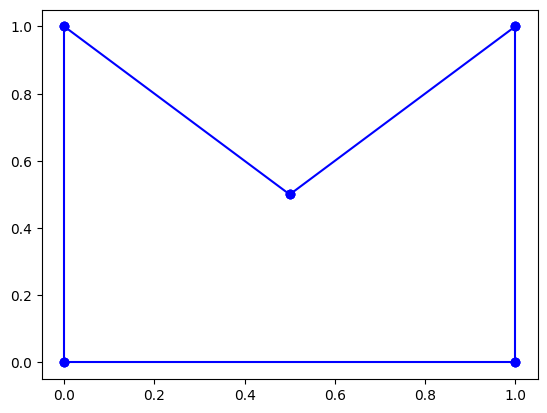

In [5]:
points = [(0,0), (0,1), (1,0), (1,1), (0.5,0.5)]
points = np.array(points)
edges = [((0,0),(0,1)), ((0,1),(0.5,0.5)), ((0.5,0.5),(1,1)), ((1,1),(1,0)), ((1,0),(0,0))]
plot_points_edges(points, edges)

In [6]:
parity_algorithm(0,0,edges)

(0, 0) is a vertex.


In [7]:
parity_algorithm(0.2,0.8,edges)

(0.2, 0.8) is a boundary point of the edge [(0, 1), (0.5, 0.5)].


In [8]:
parity_algorithm(0.2000001,0.8,edges)

(0.2000001, 0.8) is a boundary point of the edge [(0, 1), (0.5, 0.5)].


In [9]:
parity_algorithm(0.2,0.5,edges)

3

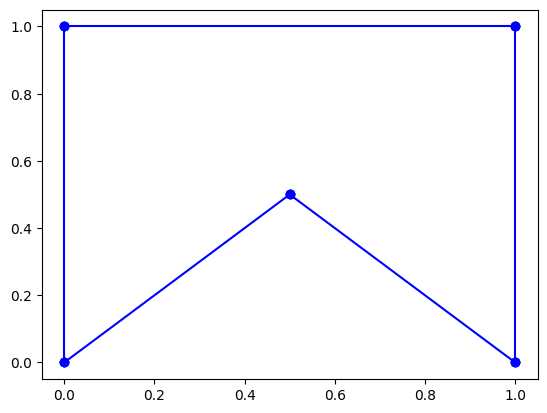

In [10]:
points = [(0,0), (0,1), (1,0), (1,1), (0.5,0.5)]
points = np.array(points)
edges = [((0,0),(0,1)), ((0,1),(1,1)), ((1,1),(1,0)), ((1,0),(0.5,0.5)), ((0.5,0.5),(0,0))]
plot_points_edges(points, edges)

In [11]:
parity_algorithm(0.2,0.5,edges)

1

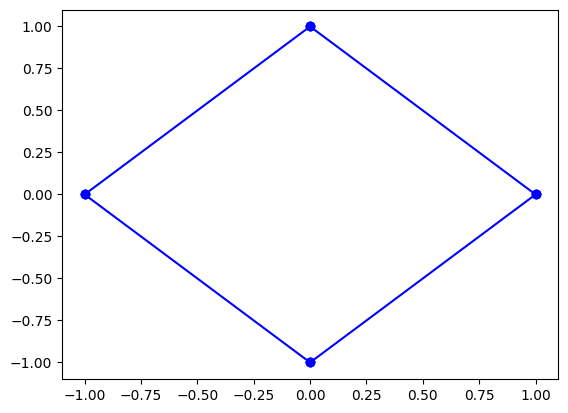

In [12]:
points = [(0,1), (1,0), (0,-1), (-1,0)]
points = np.array(points)
edges = [((0,1), (1,0)), ((1,0), (0,-1)), ((0,-1), (-1,0)), ((-1,0),(0,1))]
plot_points_edges(points, edges)

In [13]:
parity_algorithm(0,0,edges)

1

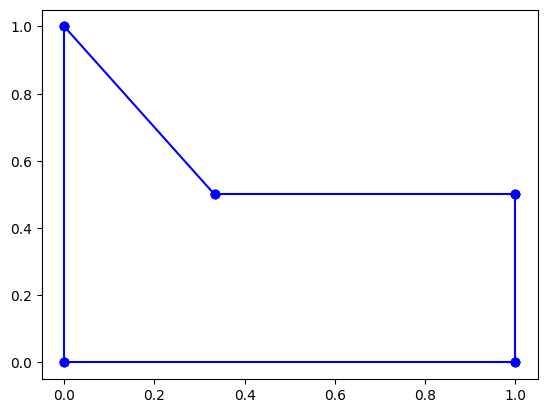

In [14]:
points = [(0,0), (0,1), (1/3,1/2), (1,1/2), (1,0)]
points = np.array(points)
edges = [((0,0), (0,1)), ((0,1), (1/3,1/2)), ((1/3,1/2), (1,1/2)), ((1,1/2), (1,0)), ((1,0),(0,0))]
plot_points_edges(points, edges)

In [15]:
parity_algorithm(0.2,0.5,edges)

1

In [16]:
parity_algorithm(-1,0.5,edges)

2

In [17]:
parity_algorithm(-1,0,edges)

2

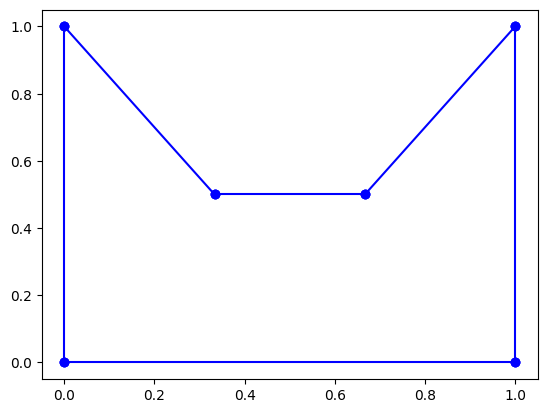

In [18]:
points = [(0,0), (0,1), (1/3,1/2), (2/3,1/2), (1,1), (1,0)]
points = np.array(points)
edges = [((0,0), (0,1)), ((0,1), (1/3,1/2)), ((1/3,1/2), (2/3,1/2)), ((2/3,1/2), (1,1)), ((1,1), (1,0)), ((1,0),(0,0))]
plot_points_edges(points, edges)

In [19]:
parity_algorithm(0.2,0.5,edges)

3

In [20]:
parity_algorithm(-1,0.5,edges)

4